# MiniProject  👁️ Image Recognition multiclass classification Landscapes  
##  🏢🌲🧊⛰️🌊🏙️
### Wesley, Keven, Didier, Celso  

### Loading Data 📦

In [1]:
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np 
from keras.preprocessing import image

path = os.getcwd()

 
image_size = (80,80)
used_color = "rgb"
color_channels = 3 if used_color == "rgb" else 1
class_labels = [
    "buildings",
     "forest",
     "glacier",
     "mountain",
     "sea",
     "street"
]

data_path = path+"/Data/seg_"

# x_train = np.ndarray((0,image_size[0],image_size[1],color_channels)) 
# x_test = np.ndarray((0,image_size[0],image_size[1],color_channels)) 

# def make_Y(TypeOfSet):
#     path=data_path+TypeOfSet
#     Data_dir_content = os.listdir(path)
#     resulting_y = []

#     for label in Data_dir_content:
#         label_dir_content = os.listdir(path+f"/{label}")

#         for _ in range(len(label_dir_content)):
#             resulting_y.append(class_labels.index(label))

#     return resulting_y

# def make_X(TypeOfSet):
#     path=data_path+TypeOfSet
#     Data_dir_content = os.listdir(path)
#     resulting_X = np.ndarray((0,image_size[0],image_size[1],color_channels))

#     for label in Data_dir_content:
#         label_dir_path=path+f"/{label}"
#         label_dir_content = os.listdir(label_dir_path)
#         print (f"step {Data_dir_content.index(label)+1}/{len(Data_dir_content)}")
#         for element in label_dir_content:
#            processed_img = prepare_img_for_model(label_dir_path+f"/{element}")
#            resulting_X = np.append(resulting_X,processed_img,axis=0)

#     return resulting_X

# def prepare_img_for_model(path):
#     img = image.load_img(path,target_size=(image_size),color_mode=used_color)
#     image_as_array = image.img_to_array(img)
#     image_reshaped = image_as_array.reshape(image_size[0],image_size[1],color_channels)
#     return np.expand_dims( image_reshaped, axis=0)


# x_test = make_X("test")
# x_train =make_X("train")


# # x_train = x_train.astype('float32')
# # x_test = x_test.astype('float32')
# # x_train /= 255
# # x_test /= 255

 
# y_train = make_Y("train")
# y_test = make_Y("test")

# # y_train = to_categorical(y_train, 6)
# # y_test = to_categorical(y_test, 6)
  

### 📁 Saving / Loading data from previous step to/from Files to save up to 120 min of processing time 

In [2]:
#save variables
# this iteration 80x80x3
#--------------------------------

# np.save(path+"/Data_ready/x_train",x_train)
# np.save(path+"/Data_ready/x_test",x_test)
# np.save(path+"/Data_ready/y_train",y_train)
# np.save(path+"/Data_ready/y_test",y_test)
 

#load variables 
# ----------------------------- 
x_train = np.load(path+"/Data_ready/x_train.npy")
x_test = np.load(path+"/Data_ready/x_test.npy")
y_train = np.load(path+"/Data_ready/y_train.npy")
y_test = np.load(path+"/Data_ready/y_test.npy")


### ➕ Data augmentation to generate slightly modified images to enlarge Dataset ➕ 

In [3]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(percent=25), # crop 10% of the iamges from each side by 0 to 1/4 of the sizepx (randomly chosen)
    # iaa.Rot90(0.25), 
    iaa.Fliplr(0.25), # horizontally flip 25% of the images
    iaa.Flipud(0.25), # Vertically flip 25% of the images
]) 

augmented_images = seq(images=x_train)

x_train = np.append(x_train,augmented_images,axis=0)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train =np.append(y_train,y_train,axis=0)

y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)

###  🚀Creating Model 

In [4]:
model = Sequential()
# 2D convolutional layers for images 1D can fit for other kind like Sound
# Params:
# 1 filters :how many differnet filters should be in the layer, one filter by pattern
# 2 kernel_size : size of the window used when creating the tiles for each image
# 3 padding: in case the kernel size doesnt match the corner ignore or fill with 0
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation='relu', input_shape=(image_size[0],image_size[1],color_channels),name="Conv2D_1"))
model.add(Conv2D(filters=64, kernel_size=(2,2),padding="same",activation='relu', name="Conv2D_2"))

#max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
#Dropout, randomly cut connections, normally used between [25-50]%
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same", activation='relu', name="Conv2D_3"))
model.add(Conv2D(filters=64, kernel_size=(2,2),padding="same",activation='relu',name="Conv2D_4"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#To transition from Convolutional layers to Dense layers we need to tell karas that we no longer want to use 2D data
model.add(Flatten())
model.add(Dense(512,activation='relu', name="DenseLayer_1"))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu', name="DenseLayer_2"))
# when doing classificaton with more than one kind of object we almost always use softmax activator for the output
model.add(Dense(6, activation="softmax", name="output_layer"))
model.summary()

2022-04-02 20:28:23.883542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:23.934710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:23.934986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:23.936291: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 80, 80, 64)        1792      
                                                                 
 Conv2D_2 (Conv2D)           (None, 80, 80, 64)        16448     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 40, 40, 64)        36928     
                                                                 
 Conv2D_4 (Conv2D)           (None, 40, 40, 64)        16448     
                                                        

o
2022-04-02 20:28:24.559426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:24.559663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:24.559789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 20:28:24.560139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3372 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

### Training the model

In [6]:
from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
#We use the ModelCheckpoint API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.
# tensorboard --logdir=/home/celso/Documents/DeepLearning/ImageClassification/MiniProject/logs
runPath = path+"/logs/22thRun"
# runPath = path+"/logs/EigthRun"
logger =  keras.callbacks.TensorBoard(
    log_dir=runPath,
    write_graph=True, #log the structure of the model
    histogram_freq =5 #how each layer is working (for every 5 passes of the training data)
)
callbacks=[EarlyStopping(patience=5, monitor="loss")]
# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

model.fit(
    x_train,
    y_train,
    batch_size=24,
    epochs=15,
    validation_data=(x_test, y_test),
    shuffle=True,
    # callbacks=[logger]
    # callbacks=[logger,checkpointer]
    callbacks=[logger,EarlyStopping(patience=2, monitor="loss")]
)


2022-04-02 20:28:24.811740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155622400 exceeds 10% of free system memory.
2022-04-02 20:28:26.451937: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155622400 exceeds 10% of free system memory.


Epoch 1/15


2022-04-02 20:28:28.887759: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-02 20:28:29.717006: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-02 20:28:29.718978: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-02 20:28:29.718998: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-02 20:28:29.721009: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-02 20:28:29.721145: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1170/1170 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.6186

2022-04-02 20:31:46.890596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3145728000 exceeds 10% of free system memory.


1170/1170 [==============================] - 203s 170ms/step - loss: 0.9742 - accuracy: 0.6186 - val_loss: 0.6455 - val_accuracy: 0.7750
Epoch 2/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.6268 - accuracy: 0.7699 - val_loss: 0.6961 - val_accuracy: 0.7580
Epoch 3/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.4951 - accuracy: 0.8215 - val_loss: 0.5165 - val_accuracy: 0.8223
Epoch 4/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.3915 - accuracy: 0.8567 - val_loss: 0.5310 - val_accuracy: 0.8257
Epoch 5/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.3081 - accuracy: 0.8900 - val_loss: 0.5248 - val_accuracy: 0.8433
Epoch 6/15
1170/1170 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9148

2022-04-02 20:48:01.881687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3145728000 exceeds 10% of free system memory.


1170/1170 [==============================] - 197s 169ms/step - loss: 0.2444 - accuracy: 0.9148 - val_loss: 0.6102 - val_accuracy: 0.8263
Epoch 7/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.1952 - accuracy: 0.9296 - val_loss: 0.7561 - val_accuracy: 0.8170
Epoch 8/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.1734 - accuracy: 0.9398 - val_loss: 0.6396 - val_accuracy: 0.8343
Epoch 9/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.1406 - accuracy: 0.9535 - val_loss: 0.7653 - val_accuracy: 0.8160
Epoch 10/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.1220 - accuracy: 0.9591 - val_loss: 0.7803 - val_accuracy: 0.8417
Epoch 11/15
1170/1170 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9595

2022-04-02 21:04:14.835160: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3145728000 exceeds 10% of free system memory.


1170/1170 [==============================] - 195s 167ms/step - loss: 0.1171 - accuracy: 0.9595 - val_loss: 0.9166 - val_accuracy: 0.8193
Epoch 12/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.1060 - accuracy: 0.9646 - val_loss: 0.9623 - val_accuracy: 0.8320
Epoch 13/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.0976 - accuracy: 0.9679 - val_loss: 0.7836 - val_accuracy: 0.8367
Epoch 14/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.0919 - accuracy: 0.9702 - val_loss: 0.8615 - val_accuracy: 0.8363
Epoch 15/15
1170/1170 [==============================] - 194s 166ms/step - loss: 0.0934 - accuracy: 0.9693 - val_loss: 0.9371 - val_accuracy: 0.8317


In [7]:

test_error_rate = model.evaluate(x_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: [0.937086820602417, 0.8316666483879089]


### 📥 Saving model structure and weights

In [8]:
# Save neural network structure
model_structure = model.to_json()
f = Path(path+"/SavedModel/model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights(path+"/SavedModel/model_weights.h5")

### 📤 Loading model structure and weights

In [ ]:
# # Load the json file that contains the model's structure
# f = Path(path+"/SavedModel/model_structure.json")
# model_structure = f.read_text()
# # Recreate the Keras model object from the json data
# model = model_from_json(model_structure)
# model.load_weights(path+"/SavedModel/model_weights.h5")

## --------------------------------------------------Testing Random Landscape Images --------------------------------------------------

---------------------------🔍Results🔍----------------------------- 

For the image of: forest.jpg
The trained model predicted this image is a forest
ResNet50 predicted the image is a mountain_bike
---------------------------------------------------------------------- 

For the image of: building.jpg
The trained model predicted this image is a buildings
ResNet50 predicted the image is a breakwater
---------------------------------------------------------------------- 

For the image of: glacier.jpg
The trained model predicted this image is a glacier
ResNet50 predicted the image is a alp
---------------------------------------------------------------------- 

For the image of: mountain.jpg
The trained model predicted this image is a mountain
ResNet50 predicted the image is a alp
---------------------------------------------------------------------- 

For the image of: sea.jpg
The trained model predicted this image is a sea
ResNet50 predicted the image is a breakwater
---------------------

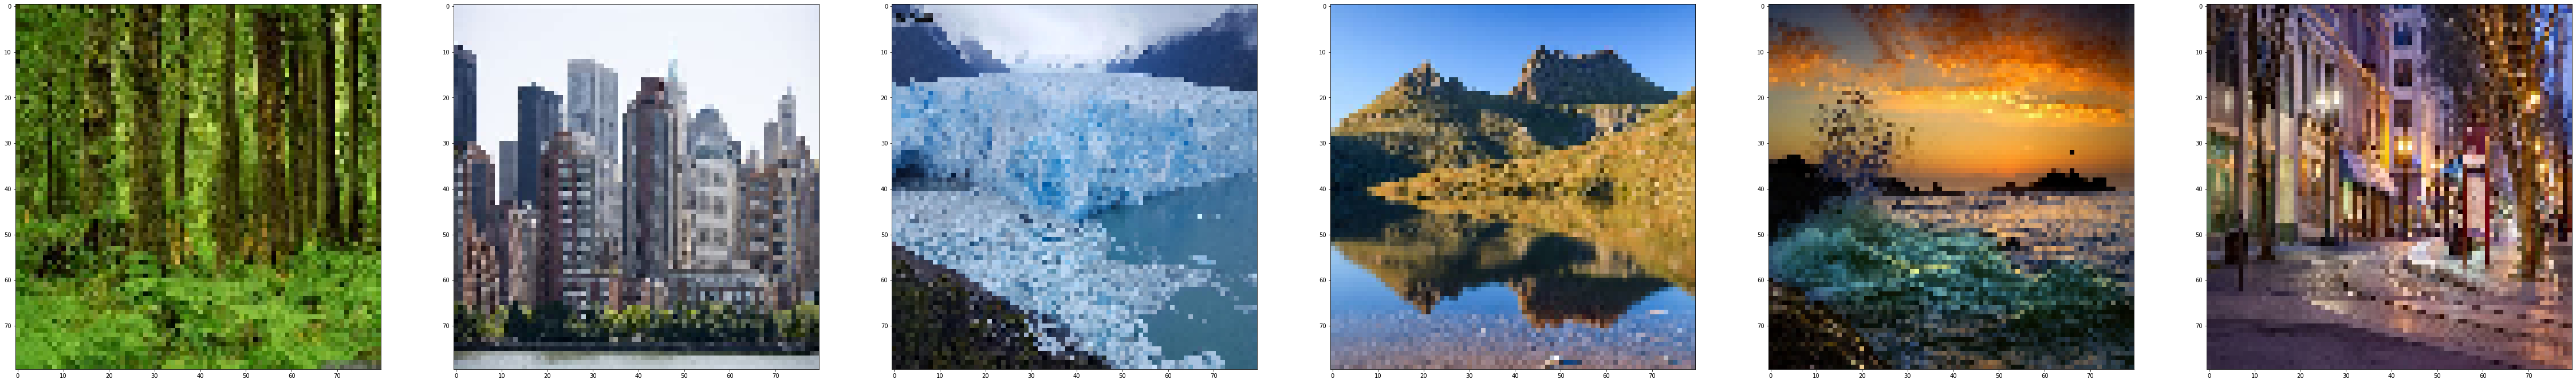

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
import re


 
pretrained_model = ResNet50(weights='imagenet')

def prepare_img_for_prediction(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

test_images = [
path+"/Data/RandomTestPics/forest.jpg",
path+"/Data/RandomTestPics/building.jpg",
path+"/Data/RandomTestPics/glacier.jpg",
path+"/Data/RandomTestPics/mountain.jpg",
path+"/Data/RandomTestPics/sea.jpg",
path+"/Data/RandomTestPics/street.jpg"
]

figure, axes = plt.subplots(1, 6, figsize=(image_size[0],image_size[1])) 
print("---------------------------🔍Results🔍----------------------------- \n")
for img_path in test_images:
    
    print(f"For the image of: {img_path.split('/')[9]}")
    resNet_image = image.load_img(img_path, target_size=(224, 224))
    model_image = image.load_img(img_path, target_size=(image_size),color_mode=used_color)
    
    axes[test_images.index(img_path)].imshow(model_image)
    plt.imshow(model_image)

    model_image_ready = prepare_img_for_prediction(model_image)

    result = model.predict(model_image_ready)[0]
    most_likely_class_index = int(np.argmax(result))
    class_label = class_labels[most_likely_class_index]
    print(f"The trained model predicted this image is a {class_label}")

    pretrained_image_ready = prepare_img_for_prediction(resNet_image)
    pretrained_image_ready= preprocess_input(pretrained_image_ready)

    preds = pretrained_model.predict(pretrained_image_ready)
    predicted_classes = decode_predictions(preds, top=1)

    print(f"ResNet50 predicted the image is a {predicted_classes[0][0][1]}")
    print("---------------------------------------------------------------------- \n")

plt.show()
